In [1]:
import copy

import chembl_downloader
from lxml import etree
from rdkit import Chem
from rdkit.Chem import Draw, molzip, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole

Draw.SetComicMode = True
Draw.rdDepictor.SetPreferCoordGen(True)

In [2]:
version = chembl_downloader.latest()
version

'31'

In [3]:
root = chembl_downloader.get_monomer_library_root(version=version)

In [4]:
monomer_list = root[0][0][:]

In [5]:
list(monomer_list[0])

[<Element '{lmr}MonomerID' at 0x124d3fe20>,
 <Element '{lmr}MonomerSmiles' at 0x124d3ff10>,
 <Element '{lmr}MonomerMolFile' at 0x125164040>,
 <Element '{lmr}MonomerType' at 0x125164130>,
 <Element '{lmr}PolymerType' at 0x125164220>,
 <Element '{lmr}NaturalAnalog' at 0x125164310>,
 <Element '{lmr}MonomerName' at 0x125164400>,
 <Element '{lmr}Attachments' at 0x1251644f0>]

In [6]:
mols = []
for m in monomer_list:
    mol = Chem.MolFromSmiles(m[1].text)
    if mol is None:
        continue
    mol.SetProp("Type", m[3].text)
    mols.append(mol)

[12:42:26] atom 35 is not associated with bond 39 in w block
[12:42:26] atom 16 is not associated with bond 17 in w block


In [7]:
len(mols)

2849

In [8]:
def combine_fragments(m1, m2):
    m1 = Chem.Mol(m1)
    m2 = Chem.Mol(m2)
    for atm in m1.GetAtoms():
        if atm.HasProp("atomLabel") and atm.GetProp("atomLabel") == "_R2":
            atm.SetAtomMapNum(1)
    for atm in m2.GetAtoms():
        if atm.HasProp("atomLabel") and atm.GetProp("atomLabel") == "_R1":
            atm.SetAtomMapNum(1)
    return molzip(m1, m2)


def make_peptide(monomerlist):
    monomerlist = copy.deepcopy(monomerlist)
    for idx, monomer in enumerate(monomerlist):
        if Chem.MolToSmiles(monomer).count("*") == 1:
            continue
        if idx == 0:
            res = monomer
        else:
            res = combine_fragments(res, monomer)
    return res


def cap_terminal(m):
    m = Chem.Mol(m)
    n_term = Chem.MolFromSmiles("CC(=O)[*:1]")
    c_term = Chem.MolFromSmiles("CO[*:2]")
    for atm in m.GetAtoms():
        if atm.HasProp("atomLabel") and atm.GetProp("atomLabel") == "_R1":
            atm.SetAtomMapNum(1)
        if atm.HasProp("atomLabel") and atm.GetProp("atomLabel") == "_R2":
            atm.SetAtomMapNum(2)
    res = molzip(m, n_term)
    res = molzip(res, c_term)
    return res

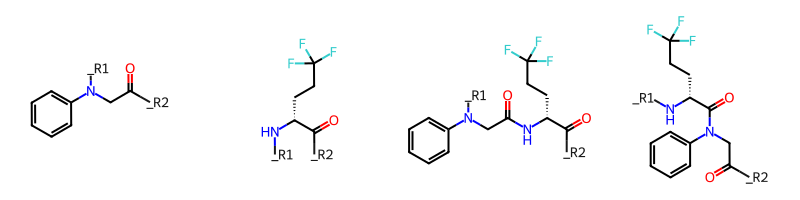

In [9]:
m1 = combine_fragments(mols[1], mols[2])
m2 = combine_fragments(mols[2], mols[1])
Draw.MolsToGridImage([mols[1], mols[2], m1, m2], molsPerRow=4, useSVG=True)

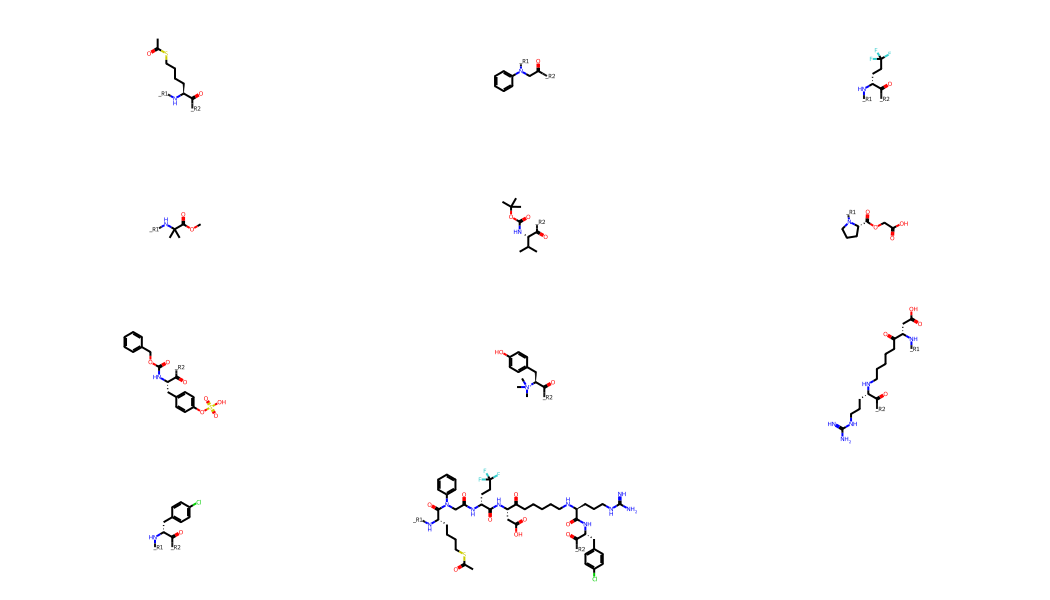

In [17]:
m3 = make_peptide(mols[:10])
Draw.MolsToGridImage(mols[:10] + [m3], molsPerRow=3, subImgSize=(350, 150), useSVG=True)

[12:42:27] Incomplete atom labelling, cannot make bond


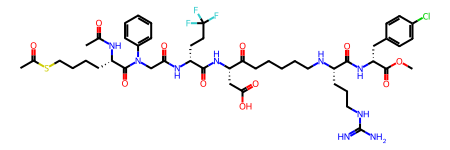

In [11]:
cap_terminal(m3)